In [1]:
using FermiCG
using PyCall
using Plots
using LinearAlgebra

Define molecule and run HF

In [2]:
molecule = "
C     1.259020     0.711710     0.000000
C     2.503660     1.386310     0.000000
C     3.708550     0.701730     0.000000
C     3.708550    -0.701730     0.000000
C     2.503660    -1.386310     0.000000
C     1.259020    -0.711710     0.000000
C    -0.013150    -1.446190     0.000000
C    -0.051250    -2.861390     0.000000
C    -1.246560    -3.562570     0.000000
C    -2.461990    -2.860840     0.000000
C    -2.452410    -1.475080     0.000000
C    -1.245860    -0.734490     0.000000
C    -1.245860     0.734490     0.000000
C    -0.013150     1.446190     0.000000
C    -0.051250     2.861390     0.000000
C    -1.246560     3.562570     0.000000
C    -2.461990     2.860840     0.000000
C    -2.452410     1.475080     0.000000
H     2.529850     2.475260     0.000000
H     4.650090     1.255640     0.000000
H     4.650090    -1.255640     0.000000
H     2.529850    -2.475260     0.000000
H     0.878710    -3.428550     0.000000
H    -1.237620    -4.654920     0.000000
H    -3.412460    -3.399270     0.000000
H    -3.408560    -0.953290     0.000000
H     0.878710     3.428550     0.000000
H    -1.237620     4.654920     0.000000
H    -3.412460     3.399270     0.000000
H    -3.408560     0.953290     0.000000
"

atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

cas_nel = 18
cas_norb = 18

basis = "sto-3g"

# 
# Create FermiCG.Molecule type
mol     = Molecule(0,1,atoms,basis)

mf = FermiCG.pyscf_do_scf(mol, verbose=2)
C = mf.mo_coeff
nbas = size(C)[1]
FermiCG.pyscf_write_molden(mol, C, filename="hf_canonical.molden")

# 
# Number of electrons
tot_na = (18*6 + 12) ÷ 2
tot_nb = (18*6 + 12) ÷ 2
tot_n_elec = tot_na + tot_nb


sto-3g


102-element Array{Float64,1}:
 -11.041075708840053
 -11.041075673288894
 -11.040924278756746
 -11.040858789784883
 -11.04083193647386
 -11.040831850226548
 -11.029827383791112
 -11.029827238310002
 -11.029826431183302
 -11.029624820369254
 -11.029623773823342
 -11.02962364306834
 -11.027538286435924
   ⋮
   0.9248900757672088
   0.9248937417480887
   0.9286254956798242
   0.9387291787313315
   0.9387326884770245
   0.9713920279356373
   1.0676391635117328
   1.0676408349507354
   1.114553864866198
   1.114554178398731
   1.1641697794043098
   1.1900130901612465

MO Energies


120

Now separate π and σ spaces. For now, I've manually inspected the orbitals to separate out the π space. However, we eventually will want automated ways to do this.

In [92]:
#
# Get active space
act_space = [46, 51, 52, collect(55:68)..., 72]
n_frozen = 51
#n_frozen = 4*18 + 12
inactive_space = setdiff(1:nbas,act_space)


occ_space = inactive_space[1:n_frozen]
vir_space = inactive_space[n_frozen+1:end]
Cact = C[:,act_space]
Cocc = C[:,occ_space]
Cvir = C[:,vir_space]

n_core = 18
core_space = inactive_space[1:n_core]
sig_space = inactive_space[n_core+1:end]
Csig = C[:,sig_space]

#
# Localize Orbitals
Cact = FermiCG.localize(Cact, "boys", mf)
Csig = FermiCG.localize(Csig, "boys", mf)
FermiCG.pyscf_write_molden(mol, Cact, filename="act.molden")
FermiCG.pyscf_write_molden(mol, Csig, filename="sig.molden")



Set conv_tol_grad to 0.000316228
macro= 1  f(x)= -485.57895358516  delta_f= -485.579  |g|= 0.0469574  1 KF 3 Hx
macro= 2  f(x)= -485.57895358516  delta_f= 0  |g|= 2.81338e-07  1 KF 1 Hx
macro X = 2  f(x)= -485.57895358516  |g|= 2.81338e-07  4 intor 2 KF 4 Hx
Set conv_tol_grad to 0.000316228
macro= 1  f(x)= -2316.395402085  delta_f= -2316.4  |g|= 2.87731  4 KF 20 Hx
macro= 2  f(x)= -2327.3483633318  delta_f= -10.953  |g|= 1.92281  4 KF 20 Hx
macro= 3  f(x)= -2329.9862808713  delta_f= -2.63792  |g|= 0.545222  3 KF 9 Hx
macro= 4  f(x)= -2329.9966156143  delta_f= -0.0103347  |g|= 0.000104793  3 KF 7 Hx
macro= 5  f(x)= -2329.9966156143  delta_f= 0  |g|= 5.78963e-05  1 KF 1 Hx
macro X = 5  f(x)= -2329.9966156143  |g|= 5.78963e-05  10 intor 15 KF 57 Hx


1

Using these orbitals, let's semi-algorithmically cluster the system. We'll start by separately looking at the π and σ spaces. Using these orbital orderings, we can inspect to see how local the exchange matrix is.


In [94]:
#
# Using these orbitals, let's semi-algorithmically cluster the system. 
# We'll start by separately looking at the π and σ spaces
# Using these orbital orderings, we can inspect to see how local the exchange matrix is
h,j,k = FermiCG.pyscf_get_jk(mol, C[:,1:tot_na] * C[:,1:tot_na]');

k1 = Cact'*(k)*Cact
k2 = Csig'*(k)*Csig
k1 = k1 - Diagonal(diag(k1))
k2 = k2 - Diagonal(diag(k2))
# p1 = heatmap(abs.(k1), aspect_ratio=:equal)
# p2 = heatmap(abs.(k2), aspect_ratio=:equal)
# plot(p1, p2, layout = @layout [a  b])

66×66 Array{Float64,2}:
  0.0           0.000701132   0.000237186  …   0.00285477    0.000632229
  0.000701132   0.0           8.74722e-5       9.27321e-5    1.73793e-5
  0.000237186   8.74722e-5    0.0             -1.25684e-5   -0.0528021
 -0.000965137  -3.45463e-5   -0.000105601     -0.0528022     7.23905e-5
 -0.0994928     0.00134408    0.000278022     -0.00276699   -0.000110236
  0.00887544   -0.000278017  -0.00134413   …   3.5497e-5    -0.00329012
 -0.00332488    2.03509e-5   -0.000192755     -0.00347305    0.000448654
 -0.10298       1.42446e-5   -0.000359367      0.00120786   -0.00111151
 -0.00879936   -0.0113124     0.00127152      -0.000583549  -6.84529e-5
  0.00610607   -0.00238238    0.00415935       1.4272e-5    -0.000993356
  0.00425652   -0.00925421   -0.00303811   …   0.000315876   3.54958e-5
  0.0516118     6.21956e-6    0.000605522     -0.000910119   0.00276703
  0.00132901    0.000112442  -0.00938498      -0.000197447   0.133729
  ⋮                                    

In [67]:
# #
# # use fiedler vector to reorder orbitals
# Cact_sorted = FermiCG.fiedler_sort(Cact,k);
# Csig_sorted = FermiCG.fiedler_sort(Csig,k);

 eigenvalues of laplacian
    1 =  -0.00000000
    2 =   0.05497939
    3 =   0.05498024
    4 =   0.19399038
    5 =   0.19399061
    6 =   0.19914957
    7 =   0.21065228
    8 =   0.25261054
    9 =   0.25261157
   10 =   0.36916483
   11 =   0.36916649
   12 =   0.36979531
   13 =   0.40329849
   14 =   0.40330060
   15 =   0.41406415
   16 =   0.52695585
   17 =   0.52695601
   18 =   0.59746107
 eigenvalues of laplacian
    1 =  -0.00000000
    2 =   0.07006603
    3 =   0.07006608
    4 =   0.24146286
    5 =   0.24146298
    6 =   0.26438620
    7 =   0.26457009
    8 =   0.35877728
    9 =   0.35877743
   10 =   0.43030577
   11 =   0.43030596
   12 =   0.43283325
   13 =   0.46053515
   14 =   0.55841504
   15 =   0.55841587
   16 =   0.67397884
   17 =   0.67397924
   18 =   0.67564619
   19 =   0.72262177
   20 =   0.72262269
   21 =   0.72289382
   22 =   0.78425203
   23 =   0.78425208
   24 =   0.78523836
   25 =   0.80232952
   26 =   0.80232988
   27 =   0.82377525
   

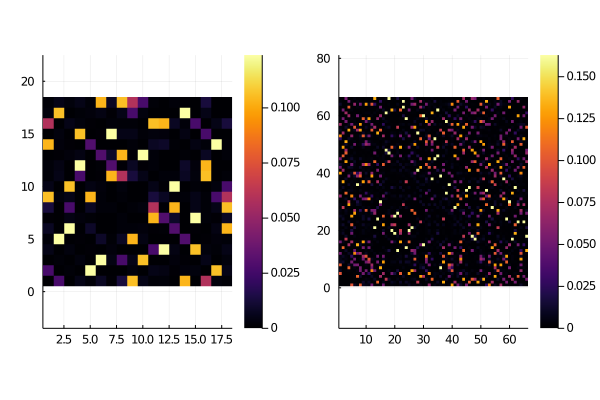

In [91]:
# # k1 = Cact_sorted'*(k)*Cact_sorted;
# # k2 = Csig_sorted'*(k)*Csig_sorted;
# k1 = Cact'*(k)*Cact;
# k2 = Csig'*(k)*Csig;
# k1 = k1 - Diagonal(diag(k1));
# k2 = k2 - Diagonal(diag(k2));
# p1 = heatmap(abs.(k1), aspect_ratio=:equal)
# p2 = heatmap(abs.(k2), aspect_ratio=:equal)
# plot(p1, p2, layout = @layout [a  b])

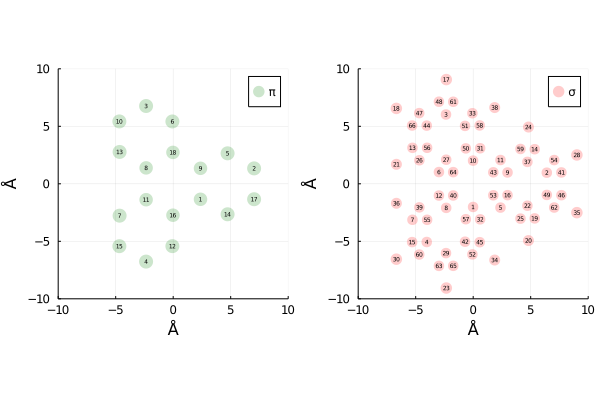

In [145]:
# 
# We can also inspect the orbital positions by looking at <r> and <r⋅r>
pymol = FermiCG.make_pyscf_mole(mol);
r1 = pymol.intor_symmetric("int1e_r");
r2 = pymol.intor_symmetric("int1e_r2");
rx_act = Cact'*r1[1,:,:]*Cact;
ry_act = Cact'*r1[2,:,:]*Cact;
rz_act = Cact'*r1[3,:,:]*Cact;
rx_sig = Csig'*r1[1,:,:]*Csig;
ry_sig = Csig'*r1[2,:,:]*Csig;
rz_sig = Csig'*r1[3,:,:]*Csig;
r2_act = Cact'*r2*Cact;
r2_sig = Csig'*r2*Csig;

var_act = diag(r2_act) - diag(rx_act).*diag(rx_act)- diag(ry_act).*diag(ry_act)- diag(rz_act).*diag(rz_act)
var_sig = diag(r2_sig) - diag(rx_sig).*diag(rx_sig)- diag(ry_sig).*diag(ry_sig)- diag(rz_sig).*diag(rz_sig)


p1 = scatter(diag(rx_act), diag(ry_act), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_act), 
    labels="π",xlims=(-10,10),ylims=(-10,10),  legendfont = font(8),    
    markeralpha = 0.2,
    markercolor = :green,
    markerstrokewidth = 0,
)

[annotate!(rx_act[i,i],ry_act[i,i],i, font(4)) for i in 1:size(rx_act,1)]

p2 = scatter(diag(rx_sig), diag(ry_sig), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_sig), 
    labels="σ",xlims=(-10,10),ylims=(-10,10),     
    markeralpha = 0.2,
    markercolor = :red,
    markerstrokewidth = 0,
)
[annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

# p3 = scatter([diag(rx_act), diag(rx_sig)], [diag(ry_act), diag(ry_sig)], aspect_ratio=:equal, 
#     markersize=5*sqrt.([var_act..., var_sig...]), 
#     labels="σ",xlims=(-10,10),ylims=(-10,10),     
#     markeralpha = 0.2,
#     markercolor = :red,
#     markerstrokewidth = 0,
# )
# [annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

plot(p1, p2, layout = @layout [a  b]
)
xlabel!("Å")
ylabel!("Å")

# 
# x and y axes are in units of Å. Each point corresponds to the mean position of the orbital, and the marker size 
# is 2*log(<r⋅r>). Thus, larger dots are more diffuse.

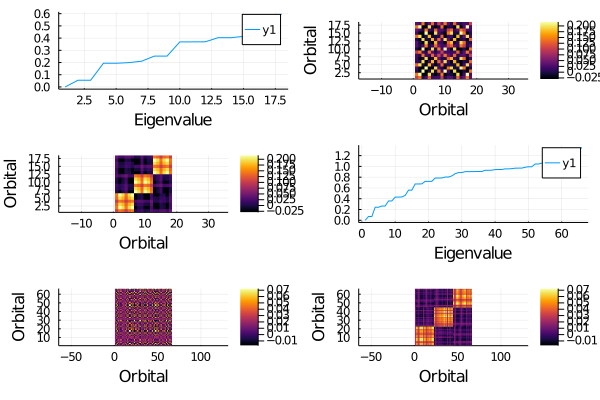

In [155]:
#
# From here, we could manually cluster. But we can instead try to use a k-means approach to spectral clustering. 
using Clustering
h,j,k = FermiCG.pyscf_get_jk(mol, C[:,1:tot_na] * C[:,1:tot_na]');


k1 = Cact'*(k)*Cact;
k2 = Csig'*(k)*Csig;

nvecs = 3
A = abs.(k1)
L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
F = eigen(L);
p1 = plot(F.values, xlabel="Eigenvalue")
A_act = F.vectors[:,1:nvecs]*F.vectors[:,1:nvecs]'
clustering_act = clusterize(KMeansClusterizer(nvecs), A_act).assignments;
perm_act = sortperm(clustering_act)
p2 = heatmap(A_act, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")
A_act = A_act[perm_act, perm_act]
p3 = heatmap(A_act, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

Cact_sorted = Cact[:,perm_act]

nvecs = 3
A = abs.(k2)
L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
F = eigen(L);
p4 = plot(F.values, xlabel="Eigenvalue")
A_sig = F.vectors[:,1:nvecs]*F.vectors[:,1:nvecs]'
p5 = heatmap(A_sig, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

clustering_sig = clusterize(KMeansClusterizer(nvecs), A_sig).assignments;
perm_sig = sortperm(clustering_sig)
A_sig = A_sig[perm_sig, perm_sig]
p6 = heatmap(A_sig, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

Csig_sorted = Csig[:,perm_sig]

plot(p1, p2, p3, p4, p5, p6, layout = @layout [a  b ;c d ;e f])



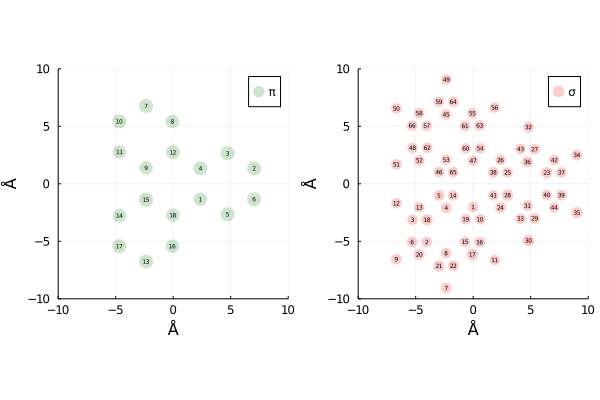

In [157]:
# 
# Now compare labelling
rx_act = Cact_sorted'*r1[1,:,:]*Cact_sorted;
ry_act = Cact_sorted'*r1[2,:,:]*Cact_sorted;
rx_sig = Csig_sorted'*r1[1,:,:]*Csig_sorted;
ry_sig = Csig_sorted'*r1[2,:,:]*Csig_sorted;
r2_act = Cact_sorted'*r2*Cact_sorted;
r2_sig = Csig_sorted'*r2*Csig_sorted;



p1 = scatter(diag(rx_act), diag(ry_act), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_act), 
    labels="π",xlims=(-10,10),ylims=(-10,10),  legendfont = font(8),    
    markeralpha = 0.2,
    markercolor = :green,
    markerstrokewidth = 0,
)



[annotate!(rx_act[i,i],ry_act[i,i],i, font(4)) for i in 1:size(rx_act,1)]

p2 = scatter(diag(rx_sig), diag(ry_sig), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_sig), 
    labels="σ",xlims=(-10,10),ylims=(-10,10),     
    markeralpha = 0.2,
    markercolor = :red,
    markerstrokewidth = 0,
    lw = 1
)

[annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

plot(p1, p2, layout = @layout [a  b]
)
xlabel!("Å")
ylabel!("Å")

# 
# x and y axes are in units of Å. Each point corresponds to the mean position of the orbital, and the marker size 
# is 2*log(<r⋅r>). Thus, larger dots are more diffuse.

In [88]:
#
# Build Integrals
ints = FermiCG.pyscf_build_ints(mol, Cact, 2.0*Cocc*Cocc');

In [8]:
#
# Define the clusters. These are tuples of orbital ranges.
clusters    = [(1:6), (7:12), (13:16)]
#
# Define the reference fock sectors. These are tuples of α, β electron counts.
# For the target clustering where we have 3 "benzene's", we'll have 6 electrons in each cluster.
init_fspace = [(3, 3),(3, 3),(3, 3)]

na = sum([i[1] for i in init_fspace])
nb = sum([i[2] for i in init_fspace])


9